# LOADED BEAM

### Introduction to the problem

Today's scenario involves a beam anchored to one side of a wall, while the other end remains free to move. We were tasked with deriving the analytical model for a specific instance: understanding the inflection and deformation when subjected to a distributed load. Our reference system places the wall-attached point as the origin and designates the other end as 1, assuming a general case of a unit-length beam.

For simplicity, we will always use the same convetion: the vertical axis pointing down to the ground, x-axe orizzontally and right-oriented. To streamline our discussion, we'll treat the entire board as a one-dimensional bar, focusing solely on its projection onto the xy plane. Consequently, all measurements are functions of x, representing the distance from the wall.

The initial conditions we consider are:

1. The displacement is zero at the wall $$ u(x=0)=0 $$
2. The derivative of the displacement is zero at the wall $$ \frac{du(x=0)}{dx}=0 $$

## 1. Second order problem

The link between 2nd derivative of displacement and position as represented by the formula $$ \frac{d^2u}{ dx^2} = - \frac{M(x)}{EJ} $$ where E is the Joung Modulus, J is the moment of inertia of the section and M is the momentum. 

### 1.1 Constant momentum


The first case we analized was the one where M(x) is constant and particularly M/EJ is equal to -1. This case represents a simplified version of the problem, allowing us to ease the subsequent equation. 
However, this model is not the most accurate representation of reality. 

We start with a double integration, resulting in the following formula 

   $$ u(x) = 1/2 x^2 + C1 x + C2. $$

In order to find the two constants we apply the following boundary conditions: 

$$ u(x=0) = 0  $$ 
and 
$$ u'(x=0) = 0. $$

The result is 

$$ u(x) = -1/2 x^2.  $$

In [51]:
using Plots
using DifferentialEquations
using BoundaryValueDiffEq
using SparseArrays
using LinearAlgebra
using BenchmarkTools
using StructArrays
using StaticArrays
using LaTeXStrings

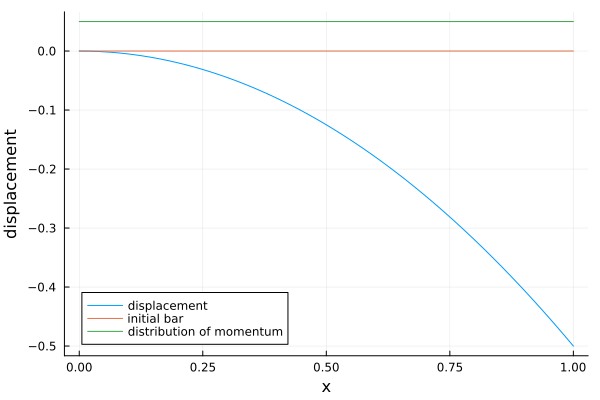

In [52]:
l=1
M(x)=-1
function f(x)
   -x^2/2*M(x)
end

x_values=range(0,l,50)

y_values=f.(x_values)

m_values=M.(x_values)

plot(x_values,-y_values,label="displacement",xlabel="x",ylabel="displacement")
plot!(x_values,0*x_values,label="initial bar")
plot!(x_values, -0.05*m_values, label="distribution of momentum")

### 1.2 Linear distribution of momentum

The second case we considered was M(x)=-F(l-x), which represents a linear distribution along the board, with  a down force at the end point. 

After a double integration, we got the  formula 

$$ u(x) = -1/6 x^3 + C1*1/2 x^2 + C2x $$


In order to find the two constants we apply the following boundary conditions:

$$ u(x=0) = 0 $$ 
and 
$$ u'(x=0) = 0. $$

The result is

$$ u(x) = 1/2 x^2-1/6 x^3. $$

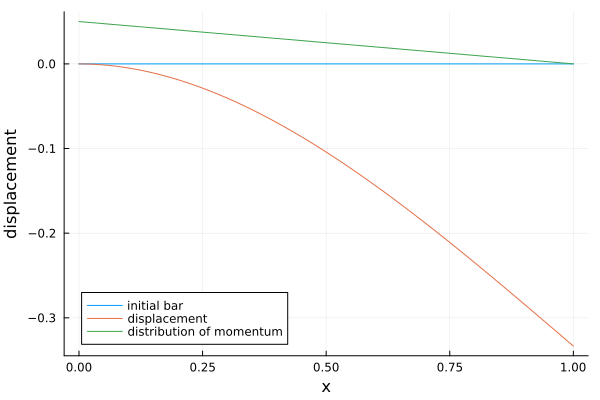

In [53]:
l1=1

F1(x)= 1
M1(x)= -F1.(x).*(l-x)

f1(x) = (x^2/2-x^3/6)*F1(x)

x_values= range(0,l,50)

y_values=f1.(x_values)

m_values=M1.(x_values)

plot(x_values,0*x_values,label="initial bar")
plot!(x_values,-y_values,label="displacement",xlabel="x",ylabel="displacement")
plot!(x_values, -0.05*m_values, label="distribution of momentum")

### 1.3 Generic distribution of momentum

We can also use numerical integration to solve a generical distribution of momentum, using the second derivative law 

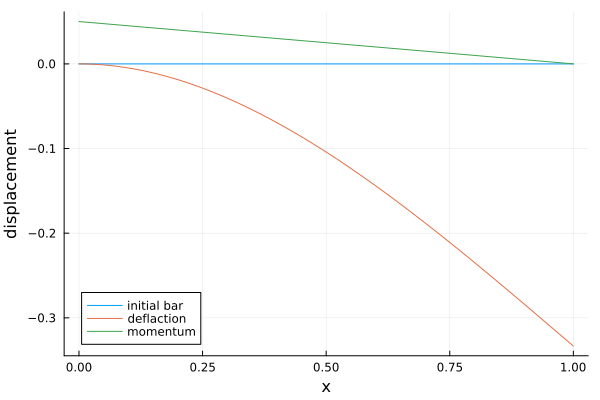

In [54]:

function M2(x)
    -1+x #momentum
end 

function beam!(du,u,p,x)   
    du[1]= u[2]
    du[2]= -M2(x)
end 

function bc!(residual,u,p,t)
    residual[1]=u[1][1]
    residual[2]=u[1][2]
end

xspan=(0,1)
bvp = BVProblem(beam!,bc!,[0.,0.],xspan)
u_sol = solve(bvp,MIRK4(),dt=0.01)

m_values=M2.(u_sol.t)

plot(u_sol.t,0*u_sol.t,label="initial bar",xlabel="x",ylabel="displacement")
plot!(u_sol.t,-u_sol[1,:],label="deflaction")
plot!(u_sol.t,-0.05*m_values,label="momentum")


### 1.4 General case with eterogeneous material

If the bar consists of multiple materials or if the geometry of the section varies along the x coordinate, incorporating factors such as size, shape, or the presence of holes, both E and J become functions of x:

$$ E \rightarrow E(x) $$

$$ J \rightarrow J(x) $$

As a result, our procedural approach in the script will undergo modification, yet the assumptions made and the ultimate results will remain unchanged.

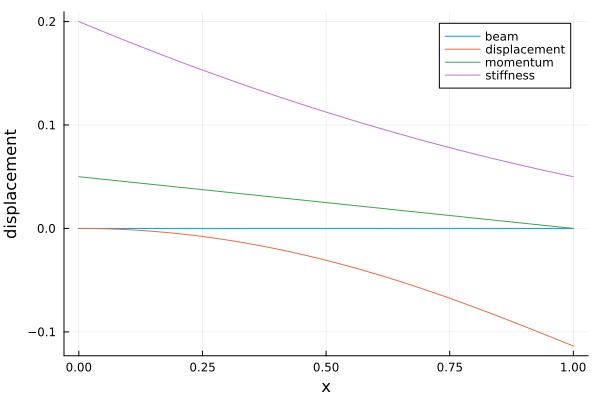

In [55]:
E3(x)=2-x                #young module equation
J3(x)=2-x                      #inertia equation
M3(x)=-(1-x);           #momentum equation

EJ(x)=(E3(x).*J3(x))     #stiffness matrix

f3(x)=-M3(x)/EJ(x)

function poisson!(du,u,p,x)
    du[1]=u[2]
    du[2]=f3(x)
end

function bc!(r,u,p,t)
    r[1] = u[1][1]
    r[2] = u[1][2]
end

xspan=(0.0 , 1.0)

bvp= BVProblem(poisson!,bc!,[0.,0.],xspan)
u_sol= solve(bvp,MIRK4(),dt = 0.01)

plot(u_sol.t,0*u_sol.t,label="beam",xlabel="x",ylabel="displacement")
plot!(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,-0.05*M3.(u_sol.t),label="momentum") #0.05 is a factor scale to represent both momentum and deflection
plot!(u_sol.t,0.05*EJ.(u_sol.t),label="stiffness")

By reducing the stifness along the x coordinate we can see how, using a linear momentum distribution, we get a different displacement which resembles the one we obtained with the constant momentum with constant stiffness (the curvature at the end is reduced, so we limited end-effectors)

## 2. Biharmonic equation solving 

The bi-harmonic equation is expressed as:

$$ \frac{d^4u}{dx^4} = \frac{q(x)}{EJ} $$

Here, q(x)  represents the distribution of loads along the bar. 

### 2.1 Constant load

Starting from the most simple case, we will substitute $ \frac{q(x)}{EJ} $ with g(x) and set g(x)  equal to a constant, specifically $ g(x) = 1 $ implying  $ q = EJ $

To fulfill the four necessary initial conditions, we can consider as an example the beam stuck to the wall previusly studied: 

$$ u(0) = 0 $$

$$ \frac{du(0)}{dx} = 0 $$

$$ \frac{d^2u(l)}{dx^2} = 0 $$

$$ \frac{d^3u(l)}{dx^3} = 0 $$

Following four rounds of integration, we arrive at the formula:

$$ u(x) = -\frac{1}{24}(l-x)^4 - \frac{1}{6}l^3x + \frac{1}{24}l^4 $$


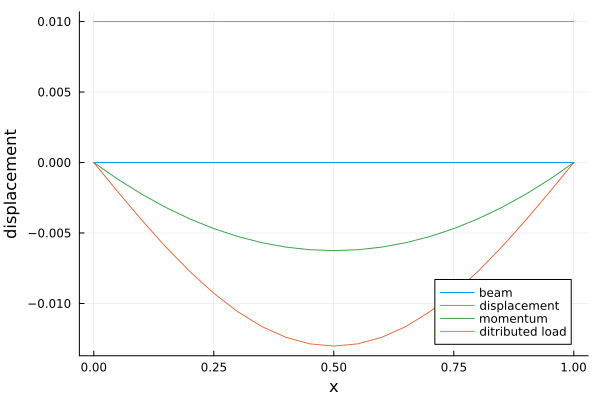

In [56]:
q(x) = 1

function beamEqt!(du,u,p,x)
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = q(x)
end

function bc!(residual,u,p,x)
    residual[1] = u[1][1]     #first number is the point we are considering, the secon one is the derivative
    residual[2] = u[end][1]
    residual[3] = u[1][3]
    residual[4] = u[end][3]
end

xspan = (0,1)
bvp = BVProblem(beamEqt!, bc!, [0.,0.,0.,0.], xspan)
sol = solve(bvp, MIRK4(), dt = 0.05)

plot(sol.t,0*sol.t,label="beam",xlabel="x",ylabel="displacement")
plot!(sol.t,-sol[1,:],label="displacement")
plot!(sol.t,0.05*sol[3,:],label="momentum")
plot!(sol.t,0.01*q.(sol.t),label="ditributed load")


### 2.2 General distribution oh the load on the bar

Once we define the solution for the easiest case, we moved to the most general one: a general distribution of loads along the length of the bar, using functions from the DifferentialEquation package to solve all the four integrations in order to reach u(x). 
In this case we solve the Poisson equation $$ \frac{du^4}{dx^4} = f(x) $$ letting f(x) free to change in order to represent the reality in the best way. 

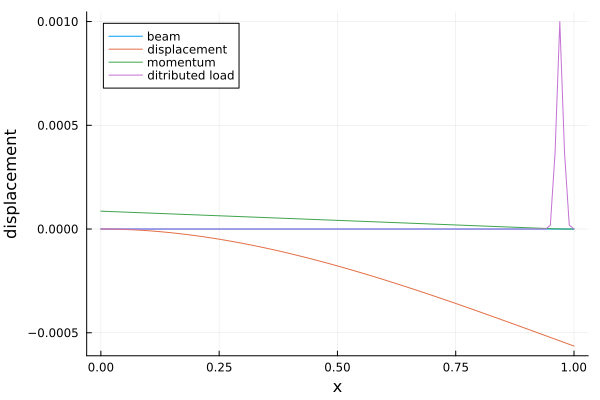

In [57]:
Am=0.1
x0=0.97
sigma=10^-4
q(x) = Am*exp(-(x-x0).^2/sigma)

function beamEqt!(du,u,p,x)
    du[1] = u[2]
    du[2] = u[3]
    du[3] = u[4]
    du[4] = q(x)
end

function bc!(residual,u,p,x)
    residual[1] = u[1][1]     #first number is the point we are considering, the secon one is the derivative
    residual[2] = u[1][2]
    residual[3] = u[end][3]
    residual[4] = u[end][4]
end

xspan = (0,1)
bvp = BVProblem(beamEqt!, bc!, [0.,0.,0.,0.], xspan)
sol = solve(bvp, MIRK4(), dt = 0.01)

plot(sol.t,0*sol.t,label="beam",xlabel="x",ylabel="displacement")
plot!(sol.t,-sol[1,:],label="displacement")
plot!(sol.t,0.05*sol[3,:],label="momentum")
plot!(sol.t,0.01*q.(sol.t),label="ditributed load")

### 2.3 General distribution oh the load on the bar (E,J variables)

If the stiffness depends on the x coordinate, the expression of the biharmonic problems is shown in this way:

$$ \frac{d^2 }{dx^2}[EJ \frac{d^2 u}{dx^2}] =f(x) $$

We have to consider a new beam equation that now accounts for these changes starting from the Poisson equation, which isn't influenced by those variations:

$$

u''\cdot E(x)J(x) = -M(x) 

\quad \rightarrow \quad

\left( u''\cdot E(x)J(x) \right)'= \left( -M(x)\right)' = -T(x)

\quad \rightarrow \quad

\left( u''\cdot E(x)J(x) \right)''= \left( -T(x)\right)' = q(x)

$$

In this way e get a new form of the beam equation that accounts for the variability of the stiffness:

$$ \dfrac{d^2}{dx^2} \left[ \dfrac{d^2u}{dx^2} \cdot E(x)J(x) \right] = q(x) $$

So now to solve the differential equation we can divide it in two differential equations and solve the system:

$$

\begin{cases}
    u'' \cdot E(x) J(x) =v \\
    v''=q(x)
\end{cases}

\qquad \Rightarrow \qquad

\begin{cases}
    u' = u_2 \\
    u'' =v / E(x) J(x)\\
    v'=u_4 \\
    v''=q(x)
\end{cases}

\qquad \Rightarrow \qquad

\underline{du} =
\begin{bmatrix}
   u' \\
   u'' \\
   v' \\
   v'' \\
\end{bmatrix}

\quad

\underline{u} =
\begin{bmatrix}
   u_1 = u = u(x)      \\
   u_2 = u' = -\varphi (x) \\
   u_3 = v = -M(x)     \\
   u_4 = v' = -T(x)    \\
\end{bmatrix}

$$

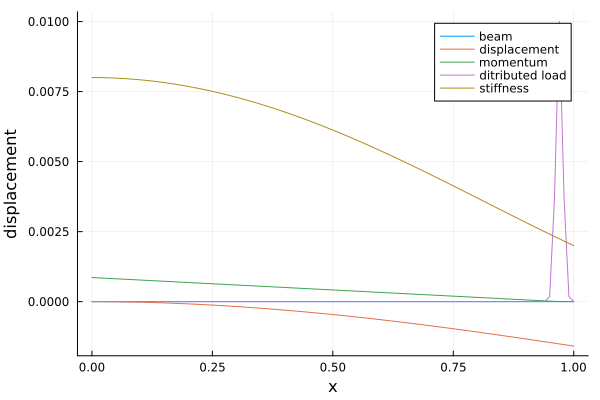

In [58]:
Am=1
x0=0.97
sigma=10^-4
q2(x) = Am*exp(-(x-x0).^2/sigma)

E4(x)=2-x^2           #young module equation
J4(x)=2-x^2               #inertia equation
EJ4(x)=E4(x)*J4(x)

function beamEqt!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]./EJ4(x)
    du[3]=u[4]
    du[4]=q2(x)
end

function bc!(residual,u,p,x)
    residual[1] = u[1][1]     #first number is the point we are considering, the second one is the derivative
    residual[2] = u[1][2]
    residual[3] = u[end][3]     
    residual[4] = u[end][4]
end

xspan = (0,1)
bvp = BVProblem(beamEqt!, bc!, [0.,0.,0.,0.], xspan)
sol = solve(bvp, MIRK4(), dt = 0.01)

plot(sol.t,0*sol.t,label="beam",xlabel="x",ylabel="displacement")
plot!(sol.t,-sol[1,:],label="displacement")
plot!(sol.t,0.05*sol[3,:],label="momentum")
plot!(sol.t,0.01*q.(sol.t),label="ditributed load")
plot!(sol.t,0.002*EJ4.(sol.t),label="stiffness")

We want to confrot the value of the displacement (sol[1,x]) in the 25th node for both cases of biahrmonic eqaution with EJ=constants and as variables of x:, around at quarter of the whole length (where the difeerence in EJ value is consistent)

$$ EJ_{1}(x = 0.25) = 1       \hspace{2em}    u_{1}(x = 0.25) = 4.5429339535470176e-5 $$

$$ EJ_{2}(x = 0.25) = 3.0625   \hspace{2em}   u_{2}(x = 0.25) = 1.1460250298083311e-5 $$

$$ \frac{EJ_{2}}{EJ_{1}} = 3.0625     \hspace{2em}   \frac{u_{2}}{u_{1}} = 0.25226539534292397   $$  

## 3 Biharmonic equation solving (Time dependant)

This section consider a beam with a load distribution wich depends both on time and  space coordinate in one dimension $$ u(x, t) $$ Alongside investigating the steady-state biharmonic equation, we delve into the non-stationary or time-dependent iteration of this equation. This thorough examination enables us to comprehend the dynamic behavior of the beam and appreciate the importance of distinct boundary conditions, specifically concerning moments and displacements. As previously noted, the biharmonic equation characterizes the bending characteristics of slender plates or beams. When presented in its non-stationary format, the biharmonic equation takes the following expression:

$$ \frac{\partial^4 u}{\partial x^4} - \frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} = 0, $$

This equation encompasses both spatial and temporal variations in the bending behavior of the beam.

The boundary conditions are
$$ \frac{d^2u}{dx^2}(x=L=1) = 0 $$ 
and
$$ u(x = 0) = 0 \hspace{1em} u'(x = 0) = 0 $$ 


┌ Info: Saved animation to C:\Users\marco\AppData\Local\Temp\jl_sn4x4fYjeT.gif
└ @ Plots C:\Users\marco\.julia\packages\Plots\sxUvK\src\animation.jl:156


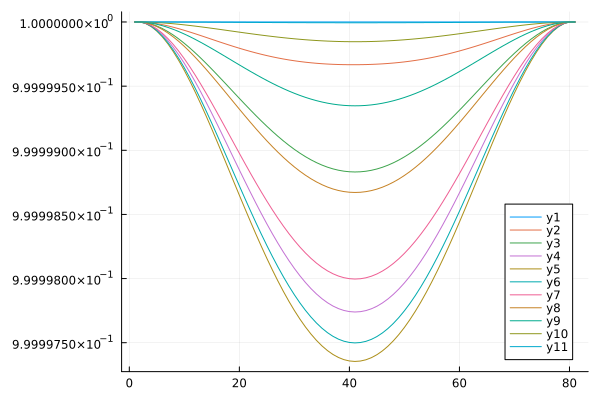

In [59]:
using WriteVTK

function set_initial_condition_1(x)
    A = 1.
    l = 80
    #-A * sin((pi / l ) * x)
    return 0 * x - 10
end

function set_initial_speed(x)
    A = 1.
    l = 80
    return A * sin((pi / l ) * x)
end
     
function source_function(x,t)
    #X0 = 40.0
    #σ = 0.8
    #A = 8000.
    #return  - A * exp(-((x - X0)^2)/σ^2)

    t0 = 0.1
    delta = 0.001
    if t<=t0 || t>t0+delta
        return 0
    else
        return 1000000
    end
    #return 10000000
end

function matrix(n)
    #Parameter
    l = 80.#length 
    dx = l/n
    E = 1.9 * 10^7
    I = 117.8 
    # Î± = E * I / dx^4
    α = E *I / dx^4
    
    # Build the matrix
    A = spdiagm( -1 => -4 *α* ones(n-1), -2 =>  α* ones(n-2), 0 =>  6  *α* ones(n)   , 1 => - 4 *α* ones(n-1), 2 =>   α*ones(n-2) )

    # Coefficient that change in the  matrix 
    A[1,2] = -1/dx
    A[1,1]=  1/dx
    A[1,3] = 0.

    A[2,1] = 1/dx^2
    A[2,2] = -2/dx^2
    A[2,3] = 1/dx^2
    A[2,4] = 0.

    A[n-1, n-3] = 0.
    A[n-1,n-2] = 1/dx
    A[n-1,n-1] =-2/dx
    A[n-1,n] = 1/dx
    
    A[n,n-2] = 0.
    A[n,n-1] = -1/dx
    A[n,n]= 1/dx

    #time 135.690 microseconds and 65 allocations for n= 2000
    return A
end

function biharmonic!(ddu,du,u,p,t)
    E = 1.9 * 10^7
    I = 117.8
    n = 81
    A = matrix(n)
    ddu .=  A * u + (1/E*I) * source_function.(x,t)
end

N = 81
L = 80.0
dx = 1
x = Vector(0.0:dx:L)

init_t = set_initial_condition_1.(x)
init_dt = set_initial_speed.(x)   # initial speed
init_dt = ones(length(init_t))

t_begin  = 0.0
t_end = 10
tspan = (t_begin, t_end)
 
prob = SecondOrderODEProblem(biharmonic!,init_dt, init_t, tspan)

# original code by Yann - no algorithm specified - used default Tsit5()
# sol = DifferentialEquations.solve(prob)

# code modified by Domenico - specify algorithm for large stiff problems 
# https://docs.sciml.ai/DiffEqDocs/stable/tutorials/advanced_ode_example/
sol = DifferentialEquations.solve(prob,TRBDF2())

Nt = 1000 # number of time samples 
dt = (t_end - t_begin)/Nt 

# Vector t holds 0 and is Nt+1 long 
tvec = Vector(t_begin:dt:Nt*dt)

#..interpolate solution in desired time samples 
U = zeros(2*N,length(tvec))
for k=1:length(tvec) 
  U[:,k] = sol(tvec[k])
end 

# animate
anim = @animate for i in 1:100
    plot(U[1:N,i],ylim=(0.99999,1.00000001))
end

gif(anim,fps=120)

#plot(U[1:N,1],ylim=(0.99999,1.00001))
#plot!(U[1:N,10],ylim=(0.99999,1.00001))
#plot!(U[1:N,20],ylim=(0.99999,1.00001))
#plot!(U[1:N,30],ylim=(0.99999,1.00001))
#plot!(U[1:N,40],ylim=(0.99999,1.00001))
#plot!(U[1:N,50],ylim=(0.99999,1.00001))
#plot!(U[1:N,end],ylim=(0.99999,1.00001))

plot(U[1:N,1])
plot!(U[1:N,10])
plot!(U[1:N,20])
plot!(U[1:N,30])
plot!(U[1:N,40])
plot!(U[1:N,50])
plot!(U[1:N,60])
plot!(U[1:N,70])
plot!(U[1:N,80])
plot!(U[1:N,90])
plot!(U[1:N,100])

### Computer simulation

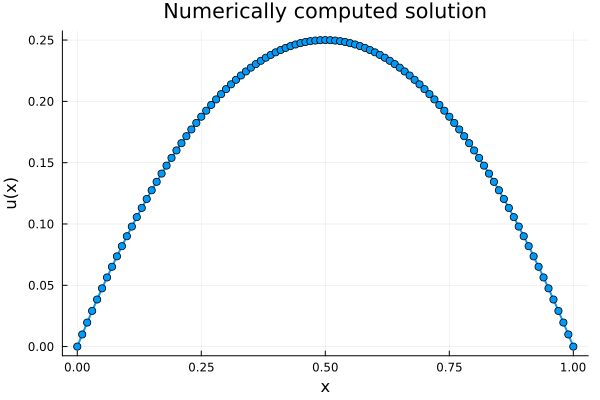

In [60]:

# struct to hold single element
struct Element
  p1::Float64
  p2::Float64
  e1::Int64
  e2::Int64
end 

function load(x)
  if 0.4<=x<=0.5
    return 1
  else
    return 0
  end
end

function fem_1d(N)    
    #..Generate the mesh 
    Np1 = N+1; h = 1/N
    x = Vector(0:h:1) 
    mesh = StructArray{Element}((x[1:end-1], x[2:end], Vector(1:N), Vector(2:N+1)))

    #..Set the source function 
    fsource(x) = 1

    #..Initialize global matrix and right-hand side value 
    f = zeros(Float64,Np1,1)
    I = zeros(Int64,4*N)
    J = zeros(Int64,4*N)
    Avalues = zeros(Float64,4*N)
    floc = zeros(Float64,2, 1)
    Aloc = zeros(Float64,2,2)

    #..Perform loop over elements and assemble global matrix and vector 
    @inbounds for i=1:N 
      xl = mesh[i].p1
      xr = mesh[i].p2
      j  = mesh[i].e1
      k  = mesh[i].e2
        
      floc = (xr-xl) * [fsource(xl), fsource(xr)];
      Aloc = (1/(xr-xl))*[1, -1, -1, 1]; 
      
      f[[j,k]] += floc 
      I[4*(i-1)+1:4*i] = [j, k, j, k]
      J[4*(i-1)+1:4*i] = [j, j, k, k]
      Avalues[4*(i-1)+1:4*i] = Aloc 
    end

    A = sparse(I,J,Avalues)

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0
    A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

    #..solve the linear system
    u = A \ f  
    return x, u 
end

x,u = fem_1d(100) 

#..plot the solution  
p1 = plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

## 4 Canter lever

If we consider a structure composed by two beams, we have to  consider the relations that each other exchange. We approch the problem as a system of tre different beams: one from the wall to the crossing point (the node), the second from the node till the end of longest beam and the support beam (which is inclined by an angle alpha).

As a result, we have a biharmonic problem for each beam, with four equation and four boundary condition each:

-two at the beginning of the firt and third beam (they are stuck to the wall)

-two at the end of the second beam (it's free to move, but momentum and sheer are 0 here)

-two between bar 1 and 2, because they represent a continuos and regular surfice (a condition  on the displacement and the first derivative)

-two between bar 1 and 3, considering that the displacement and the angle (the first derivative) 

For the last two, we have to consider not a single beam or a joint between only a couple of them, but the entire node: the equilibrium of momentum and forces is conserved. 
We have to remember that the vertical force on the third beam is one of the two components of the sheer applied on it; to obtain  we can divide by the cos(alpha).




In [67]:
Am=1
x0=0.97
sigma=10^-4
q(x) = Am*exp(-(x-x0).^2/sigma)

q1(x)=0
q2(x)=0
q3(x)=0

F2=0
W2=0

alpha=30*pi/180
l=1/cos(alpha)
y0=sin(alpha)*l

# BEAM 1,2
E1(x)=1 #2-x^2           #young module equation
J1(x)=1 #2-x^2               #inertia equation
EJ1(x)=E1(x)*J1(x)

# BEAM 3
E3(x)=1 #2-x^2           #young module equation
J3(x)=1 #2-x^2               #inertia equation
EJ3(x)=E3(x)*J3(x)

function beamEqt!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]./EJ1(x)
    du[3]=u[4]
    du[4]=q1(x)

    du[5]=u[4+2]
    du[6]=u[4+3]./EJ1(x)
    du[7]=u[4+4]
    du[8]=q2(x)

    du[9]=u[8+2]
    du[10]=u[8+3]./EJ3(x)
    du[11]=u[8+4]
    du[12]=q3(x)
end

function bc!(residual,u,p,x)
    residual[1]= u[1][1]                    # displacement start beam 1 = 0
    residual[2]= u[1][2]                    # angle start beam 1 = 0

    residual[3]= u[end][1] - u[1][4+1]      # u end beam 1 = u start beam 2
    residual[4]= u[end][2] - u[1][4+2]      # phi end beam 1 = phi start beam 2
    
    residual[5]= -u[1][4+3] + u[end][8+3] + u[end][3]               # sum of the momentums in the node
    residual[6]= -u[1][4+4] + u[end][8+4]/cos(alpha) + u[end][4]    # sum of the sheer in the node
    
    residual[7]= u[end][4+3] + W2                         # momentum end beam 2 = 0
    residual[8]= u[end][4+4] + F2                       # sheer end beam 2 = T2 (NB: v'=-T)

    residual[9]= u[1][8+1]                              # u start beam 3 = 0
    residual[10]= u[1][8+2]                             # phi start beam 3 = 0


    residual[11]= u[end][8+1]*cos(alpha) - u[end][1]    # u end beam 3 = u end beam 1
    residual[12]= u[end][2] - u[end][8+2]               # phi end 1 = phi end 3
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],xspan)
u_sol= solve(bvp,MIRK4(),dt = 0.001)

x_dis1=u_sol.t
x_dis2=u_sol.t .+ 1
x_dis= vcat(x_dis1,x_dis2)

u_dis1= -u_sol[1,:]
u_dis2= -u_sol[4+1,:]
u_dis= vcat(u_dis1,u_dis2)

x_dis3= x_dis1
b_dis3= -y0 .+ tan(alpha).*x_dis3
u_dis3= b_dis3 .- u_sol[8+1,:]*cos(alpha)

display(u_dis[end])

plot(x_dis,0*x_dis,label="beam")
plot!(x_dis3,b_dis3,label="supportbeam")

plot!(x_dis,u_dis,label="displacement")
plot!(x_dis3,u_dis3,label="support displacement")

q1_dis=q1.(u_sol.t)
q2_dis=q2.(u_sol.t)

q_dis=0.05*vcat(q1_dis,q2_dis)

plot!(x_dis,q_dis,label="load")


## 5 Scripts and other examples


Solving Poisson where M, E and J are functions of x and the beam is fixed on the left side

In [ ]:
E(x)= 2-x                   #young module equation
J(x)= 2-x                   #inertia equation
M(x)=-1;                    #momentum equation

EJ(x)= E(x)*J(x)

f(x)=-M(x)/(EJ(x))          #poisson equation


function poisson!(du,u,p,x)
    du[1]=u[2]
    du[2]=f(x)
end


function bc!(r,u,p,x)       #boundary condition of the fixed costrain
    r[1]= u[1][1] - 0  
    r[2]= u[1][2] - 0
end


xspan=(0.0 , 1.0)

bvp= BVProblem(poisson!,bc!,[0.,0.],xspan)

u_sol= solve(bvp,MIRK4(), dt = 0.05)

plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,-0.05*M.(u_sol.t),label="momentum")

plot!(u_sol.t,0.05*(EJ.(u_sol.t)),label="stifness")


We can also find the displacement starting from the distributed load $q(x)$. Let's study the case when E and J are constant along x:

$$
    
$$

beam equation with E and J constant and q as a function of x between two joints

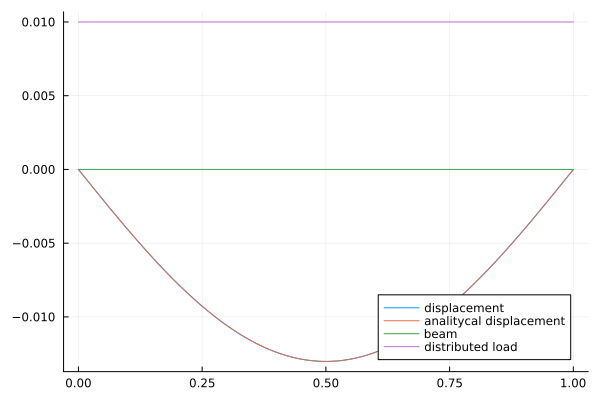

In [ ]:
q(x)=1
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[end][1]
    residual[3]= u[1][3] 
    residual[4]= u[end][3] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")

fex(x)=(x^4/24 -x^3/12 +x/24)*f(x)                              #exact analitycal solution 
plot!(u_sol.t,-fex.(u_sol.t),label="analitycal displacement")

plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.01*f.(u_sol.t),label="distributed load")



case with fixed joint in one end

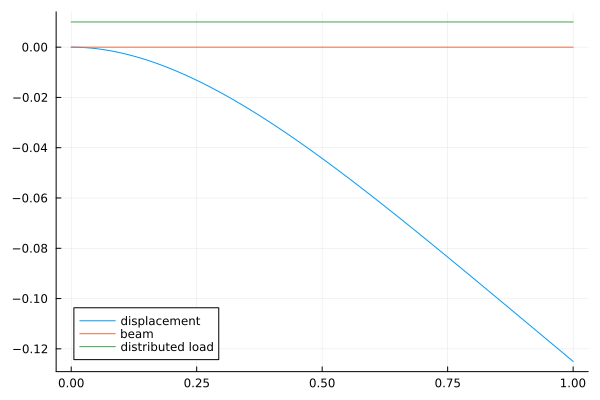

In [ ]:
q(x)=1
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[end][3]
    residual[3]= u[1][2] 
    residual[4]= u[end][4] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.01*f.(u_sol.t),label="distributed load")

we can also model an impulse momentum in the end point by putting it in the beoundary conditions 

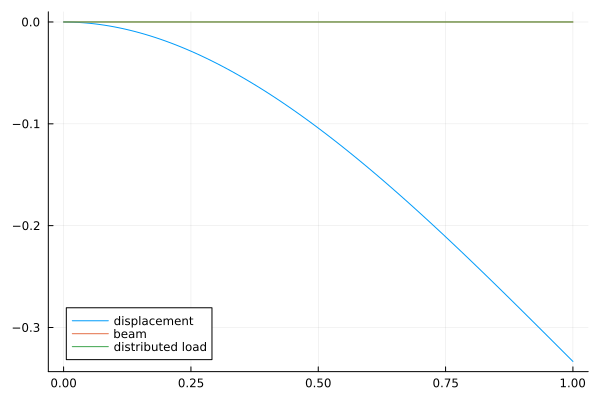

In [ ]:
q(x)=0
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[end][3]
    residual[3]= u[1][2] 
    residual[4]= u[end][4] + 1
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.01*f.(u_sol.t),label="distributed load")

between fixed constrain and joint 

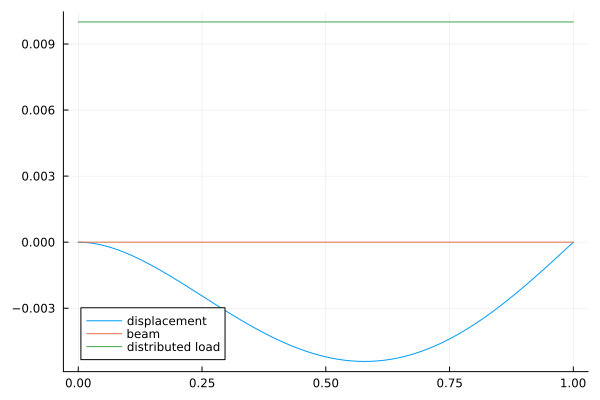

In [ ]:
q(x)=1
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[1][2]
    residual[3]= u[end][1] 
    residual[4]= u[end][3] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.01*f.(u_sol.t),label="distributed load")

between fixed costrain and skate

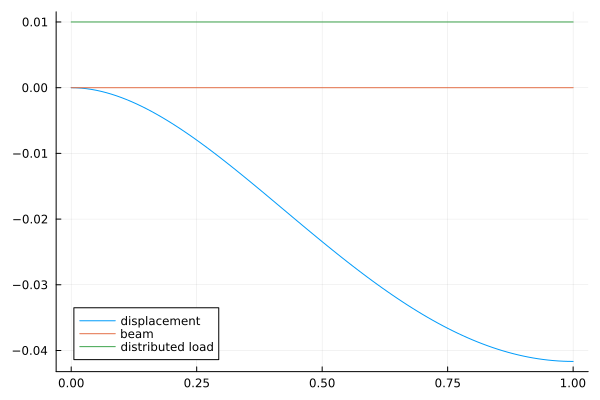

In [ ]:
q(x)=1
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[1][2]
    residual[3]= u[end][2] 
    residual[4]= u[end][4] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.01*f.(u_sol.t),label="distributed load")

between two fixed joints

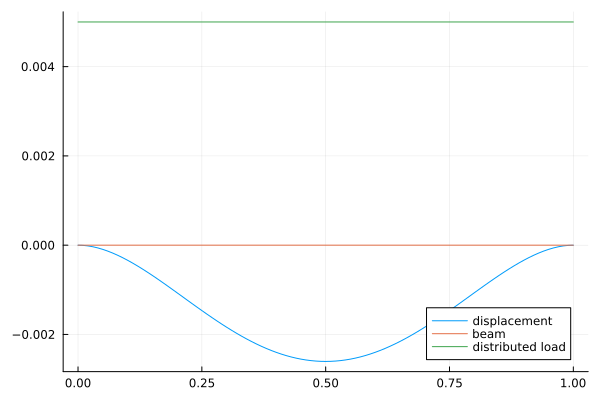

In [ ]:
q(x)=1
EJ(x)=1

f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[1][2]
    residual[3]= u[end][1] 
    residual[4]= u[end][2] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.01)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.005*f.(u_sol.t),label="distributed load")

let's try using a gaussian distribution for the load between a fixed contrain and a skate

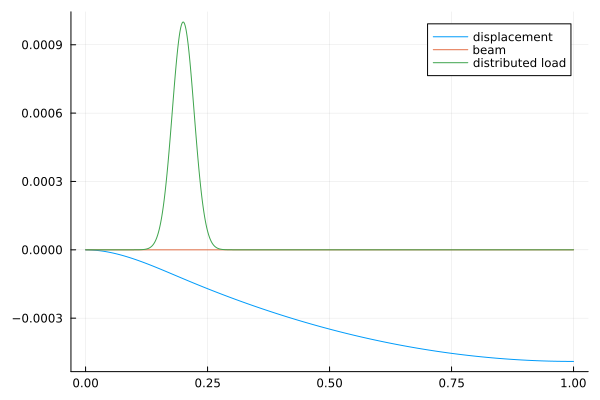

In [ ]:
A=1
x0=0.2
sigma=0.001

q(x)=A*(exp(-(x-x0)^2/sigma))

E(x)= 1               #young module equation (HAS TO BE CONSTANT)
J(x)= 1                     #inertia equation (HAS TO BE CONSTANT)
EJ(x)= E(x)*J(x)        #stiffness (HAS TO BE CONSTANT)


f(x)=q(x)/EJ(x)


function beam!(du,u,p,x)
    du[1]=u[2]
    du[2]=u[3]
    du[3]=u[4]
    du[4]=f(x)
end


function bc!(residual,u,p,x)
    residual[1]= u[1][1]
    residual[2]= u[1][2]
    residual[3]= u[end][2] 
    residual[4]= u[end][4] 
end

xspan=(0.0 , 1.0)

bvp= BVProblem(beam!,bc!,[0.,0.,0.,0.],xspan)

u_sol= solve(bvp,MIRK4(),dt = 0.001)


plot(u_sol.t,-u_sol[1,:],label="displacement")
plot!(u_sol.t,0*u_sol.t,label="beam")
plot!(u_sol.t,0.001*q.(u_sol.t),label="distributed load")